In [71]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time
from IPython import display
import import_ipynb
from util import utils

# 环境

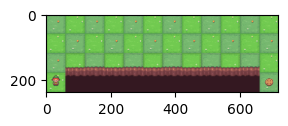

In [72]:
env = utils.CliffWalkingEnv(max_step=200)
env.reset(seed=0)
env.show()

# 算法定义

In [73]:
class DynaQ:
    """ Dyna-Q算法 """
    name = 'DynaQ'
    def __init__(self,
                 state_dim,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 action_dim):
        self.Q_table = np.zeros([state_dim, action_dim])  # 初始化Q(s,a)表格
        self.action_dim = action_dim  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型
        self.nrow = action_dim
        self.ncol = state_dim // action_dim

    def take_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, transition_dict):
        s0 = transition_dict['state']
        a0 = transition_dict['action']
        r = transition_dict['reward']
        s1 = transition_dict['next_state']
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

    def play(self, env, update=False, show=False):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = self.take_action(state)
            next_state, reward, done = env.step(action)
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                transition_dict = {
                    'state': state,
                    'action': action,
                    'reward': reward,
                    'next_state': next_state
                }
                self.update(transition_dict)
            state = next_state
        return episode_return   

    def show_q_table(self):
        for nrow in range(self.nrow):
            for ncol in range(self.ncol):
                print(np.argmax(self.Q_table[nrow * 12 + ncol]), end='    ')
            print()

# 初始化

In [74]:
np.random.seed(0)
random.seed(0)

In [75]:
state_dim = env.observation_space.n
action_dim = env.action_space.n
epsilon = 0.01
alpha = 0.1
gamma = 0.9
n_planning_list = [0, 2, 20]
agent_list = []
for n_planning in n_planning_list:
    agent_list.append(DynaQ(state_dim, epsilon, alpha, gamma, n_planning, action_dim))

In [76]:
num_episodes = 500  # 智能体在环境中运行多少条序列
epochs = 10

# 玩一局游戏（训练前）

In [77]:
agent_list[0].show_q_table()

0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    


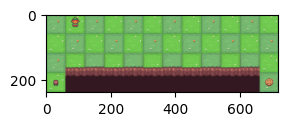

回报：-200


In [78]:
episode_return = agent_list[1].play(env, update=False, show=True)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [79]:
def train(agent):
    return_list = []  # 记录每一条序列的回报
    update = True
    show = False
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [80]:
return_lists = []
for i in range(len(n_planning_list)):
    n_planning = n_planning_list[i]
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_lists.append(train(agent_list[i]))

Q-planning步数为：0


Iteration 9: 100%|██████████████████████████████████████| 50/50 [00:00<00:00, 2007.11it/s, episode=500, return=-13.000]


Q-planning步数为：2


Iteration 9: 100%|██████████████████████████████████████| 50/50 [00:00<00:00, 1392.61it/s, episode=500, return=-23.800]


Q-planning步数为：20


Iteration 9: 100%|███████████████████████████████████████| 50/50 [00:00<00:00, 427.10it/s, episode=500, return=-13.400]


## 训练结果

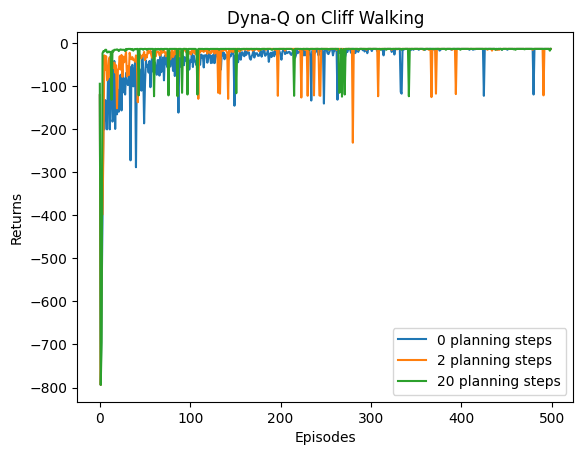

In [81]:
for i in range(len(return_lists)):
    return_list = return_lists[i]
    n_planning = n_planning_list[i]
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

# 玩一局游戏（训练后）

In [82]:
agent_list[1].show_q_table()

1    1    1    1    1    1    1    1    1    1    1    2    
1    1    1    1    1    1    1    1    1    1    2    2    
1    1    1    1    1    1    1    1    1    1    1    2    
0    0    0    0    0    0    0    0    0    0    0    0    


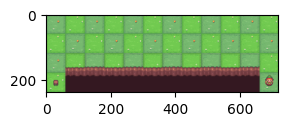

回报：-13


In [83]:
episode_return = agent_list[1].play(env, update=False, show=True)
print("回报：{}".format(episode_return))